# Multiple Multistep Time Series Analysis

By Chuanyun (Clara) Zang 

The analysis aimed to solve a Kaggle competition problem – Web Traffic Time Series Forecasting. See https://www.kaggle.com/c/web-traffic-time-series-forecasting.

Long Short Term Memory network and some basic statistic method is used in the analysis. 

### Set up libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint  


Using TensorFlow backend.


### Import Datasets

In [2]:
data = pd.read_csv('train_1.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


#### NB: These are univariate multiple time-series...

In [3]:
# DO THE SAME IN MY DATASET. 
key = pd.read_csv('key_1.csv')
key_split = key.copy()
key_split['date'] = key_split.Page.apply(lambda a: a[-10:])
key_split['Page'] = key_split.Page.apply(lambda a: a[:-11])
key_split.head()

,Page,Id,date
0,!vote_en.wikipedia.org_all-access_all-agents,bf4edcf969af,2017-01-01
1,!vote_en.wikipedia.org_all-access_all-agents,929ed2bf52b9,2017-01-02
2,!vote_en.wikipedia.org_all-access_all-agents,ff29d0f51d5c,2017-01-03
3,!vote_en.wikipedia.org_all-access_all-agents,e98873359be6,2017-01-04
4,!vote_en.wikipedia.org_all-access_all-agents,fa012434263a,2017-01-05


### Define metric functions

In [4]:
def smape_test(y_true, y_pred):
    denominator = (y_true+y_pred)/200.0
    diff = np.abs(y_true-y_pred)/denominator
    diff[denominator==0] = 0.0
    return np.mean(diff)

## Exploratory Analysis

In [5]:
data0 = data.copy()
data0.iloc[:,1:].isnull().sum(axis=0).describe()

count      550.000000
mean     11259.874545
std       5275.772841
min       3189.000000
25%       6614.500000
50%      10560.500000
75%      15792.500000
max      20816.000000
dtype: float64

In [6]:
data0 = data0.fillna(0)

0
2NE1_zh.wikipedia.org_all-access_spider


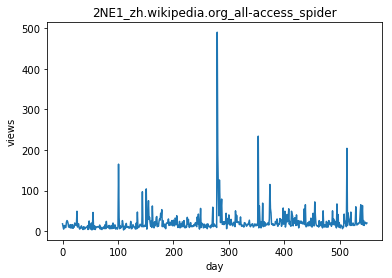

50000
Suicide_Squad_(Film)_de.wikipedia.org_all-access_spider


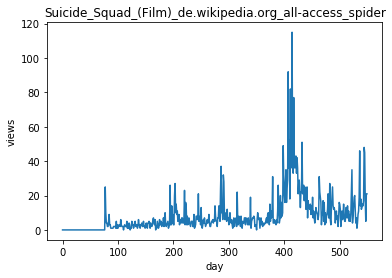

In [33]:
#for idx in [0, 5, 10000, 50000]:
for idx in [0, 50000]:
    print(idx)
    print(data0.iloc[idx,0])
    plot_entry(idx)    

## Preprocess Data

#### Save true values for checking model performence later

In [11]:
data = data.fillna(0)
#X_train = data[data.columns[1:-120]]
y_train_true = data[list(data.columns[-120:-60])]
#X_validate = data1[list(data1.columns[61:-60])]
y_validate_true = data[list(data.columns[-60:])]
#X_test = data1[list(data1.columns[121:])]

#### Work on a copy of the training data

In [34]:
data1 = data.copy()

data1['index1'] = data1.index
data1 = data1[['index1']+list(data1.columns)[1:-1]]
#data1.head(1)

#### Transform all values in dataset by using natural logarithm

In [35]:
### Take log(x+1)
data1[data1.columns[1:]] = data1[data1.columns[1:]].apply(lambda x: np.log(x+1))
#data1.head(1)

#### Define X_train, y_train, X_test, y_test

In [14]:
X_train = data1[data1.columns[1:-120]]
y_train = data1[list(data1.columns[-120:-60])]
X_validate = data1[list(data1.columns[61:-60])]
y_validate = data1[list(data1.columns[-60:])]
X_test = data1[list(data1.columns[121:])]
# Y_test missing? 

#### Normalize X_train/validate/test

In [15]:
### Normalization X so that visits in each day are in the same range
## ? yes

#range_train = (X_train.max()-X_train.min()).replace('0', '1').astype('float64')
X_train_norm = (X_train - X_train.min())/(X_train.max()-X_train.min())
#y_train_norm = (y_train - y_train.mean())/y_train.std()
#X_validate_norm = (X_validate.max()-X_validate.min()).replace('0', '1').astype('float64')
X_validate_norm = (X_validate - X_validate.min())/(X_validate.max()-X_validate.min())

X_test_norm = (X_test - X_test.min())/(X_test.max()-X_test.min())

print('X_train_norm: ', X_train_norm.shape)
print('y_validate: ', y_validate.shape)

('X_train_norm: ', (145063, 430))
('y_validate: ', (145063, 60))


#### Reshape datasets for LSTM model

In [16]:
## reshape after normalized
X_train1 = X_train_norm.values.reshape(X_train.shape[0], 1, X_train.shape[1]) # (samples, timestep, features)
X_validate1 = X_validate_norm.values.reshape(X_validate.shape[0], 1, X_validate.shape[1])
y_train1 = y_train.values
y_validate1 = y_validate.values
X_test1 = X_test_norm.values.reshape(X_test.shape[0], 1, X_test.shape[1])

## Build Models

### Define model and train on X_train, y_train and validate on X_validate, y_validate

In [18]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(256, input_shape = (1,X_train.shape[1])))
LSTM_model.add(Dropout(0.3))
LSTM_model.add(Dense(60))
LSTM_model.compile(loss = 'mean_absolute_error', optimizer = 'rmsprop')
#LSTM_model.compile(loss = smape, optimizer = 'rmsprop')

LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               703488    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                15420     
Total params: 718,908
Trainable params: 718,908
Non-trainable params: 0
_________________________________________________________________


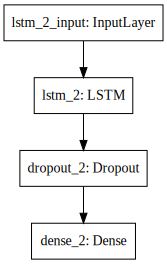

In [101]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(LSTM_model).create(prog='dot', format='svg'))

In [25]:
epochs = 10
checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch1.hdf5', verbose=1, save_best_only=True)
print('Start training...')

LSTM_model.fit(X_train1, y_train1, validation_data=(X_validate1, y_validate1), 
              epochs=epochs, callbacks=[checkpointer], verbose=1)
#LSTM_model.fit(X_train1, y_train1, validation_split=0.05, 
#               epochs=epochs, callbacks=[checkpointer], verbose=1)

Start training...
Train on 145063 samples, validate on 145063 samples
Epoch 1/10
145063/145063 [==============================] - 77s - loss: 0.6299 - val_loss: 0.5434
Epoch 2/10
145063/145063 [==============================] - 77s - loss: 0.5731 - val_loss: 0.6049
Epoch 3/10
145063/145063 [==============================] - 77s - loss: 0.5600 - val_loss: 0.6102
Epoch 4/10
145063/145063 [==============================] - 80s - loss: 0.5518 - val_loss: 0.5053
Epoch 5/10
145063/145063 [==============================] - 80s - loss: 0.5437 - val_loss: 0.5800
Epoch 6/10
145063/145063 [==============================] - 81s - loss: 0.5384 - val_loss: 0.5148
Epoch 7/10
145063/145063 [==============================] - 81s - loss: 0.5352 - val_loss: 0.5108
Epoch 8/10
145063/145063 [==============================] - 81s - loss: 0.5301 - val_loss: 0.5069
Epoch 9/10
145063/145063 [==============================] - 80s - loss: 0.5252 - val_loss: 0.4879
Epoch 10/10
145063/145063 [=====================

#### Check the model performance by using SMAPE

In [19]:
LSTM_model.load_weights('weights.best.from_scratch1.hdf5')

########## Validate model 
y_validate_pred = LSTM_model.predict(X_validate1)
#comment for LSTM
#y_validate_pred = y_validate_pred.reshape(y_validate_pred.shape[0], y_validate_pred.shape[2])
y_validate_pred1 = pd.DataFrame(data = y_validate_pred, columns = list(y_validate.columns))

##inverse to counts of visits
y_val_pred = y_validate_pred1.apply(lambda x: np.exp(x)-1)

for i in list(y_val_pred.columns):
    y_val_pred[i] = y_val_pred[i].apply(lambda x: round(x))

y_val_pred[y_val_pred<0]=0

print('SAMPE of validate set when training on X_train: ', smape_test(y_validate_true.stack(), y_val_pred.stack()))

##LSTM 46.39/ 45.5

('SAMPE of validate set when training on X_train: ', 45.944525720974546)


#### The benchmark model

In [20]:
## benckmark: median of previous 60 days
y_train_true1 = y_train.copy()
y_train_true1['V'] = y_train_true.median(axis=1)
y_train_true1.head()

for i in list(y_validate_true.columns):
    y_train_true1[i] = y_train_true1['V']

smape_test(y_validate_true.stack(), y_train_true1[y_train_true1.columns[-60:]].stack())

47.96375802400474

#### Predict on X_test, and save output by Page and date

In [21]:
## to get 'Page'
X_test_P = data[['Page']+list(data.columns[-7:])]

In [22]:
######## Predict
LSTM_model.load_weights('weights.best.from_scratch1.hdf5')

y_test_pred = LSTM_model.predict(X_test1)

out_cols = list(pd.unique(key_split['date'].values))
y_test_pred1 = pd.DataFrame(data = y_test_pred, columns = list(out_cols))

##Inverse if outlier removed
y_test_pred2 = y_test_pred1.apply(lambda x: np.exp(x)-1)

y_test_pred2[y_test_pred2<0] =0

###merge into Page
test_out = pd.merge(X_test_P, y_test_pred2, left_index = True, right_index = True)
test_out1 = test_out[['Page']+list(test_out.columns.values[-60:])]
test_out_120D = pd.melt(test_out1, id_vars='Page', var_name='date', value_name='Visits_120D')
test_out_120D.head()
#results_120D = key_split.merge(test_out2, how ='left')


,Page,date,Visits_120D
0,2NE1_zh.wikipedia.org_all-access_spider,2017-01-01,20.370663
1,2PM_zh.wikipedia.org_all-access_spider,2017-01-01,23.933784
2,3C_zh.wikipedia.org_all-access_spider,2017-01-01,5.920140
3,4minute_zh.wikipedia.org_all-access_spider,2017-01-01,15.802696
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2017-01-01,15.828934


### Retrian model on X_validate, y_validate

In [16]:
checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch2.hdf5', verbose=1, save_best_only=True)
print('Start training...')
LSTM_model.fit(X_validate1, y_validate1, validation_split = 0.05, 
               epochs=epochs, callbacks=[checkpointer], verbose=1)

Start training...
Train on 137809 samples, validate on 7254 samples
Epoch 1/10
137809/137809 [==============================] - 68s - loss: 0.5213 - val_loss: 0.5051
Epoch 2/10
137809/137809 [==============================] - 73s - loss: 0.5170 - val_loss: 0.5280
Epoch 3/10
137809/137809 [==============================] - 71s - loss: 0.5135 - val_loss: 0.5415
Epoch 4/10
137809/137809 [==============================] - 68s - loss: 0.5106 - val_loss: 0.4859
Epoch 5/10
137809/137809 [==============================] - 69s - loss: 0.5070 - val_loss: 0.5108
Epoch 6/10
137809/137809 [==============================] - 72s - loss: 0.5047 - val_loss: 0.4809
Epoch 7/10
137809/137809 [==============================] - 68s - loss: 0.5034 - val_loss: 0.5041
Epoch 8/10
137809/137809 [==============================] - 67s - loss: 0.5006 - val_loss: 0.4897
Epoch 9/10
137809/137809 [==============================] - 68s - loss: 0.4983 - val_loss: 0.5156
Epoch 10/10
137809/137809 [=======================

In [17]:
LSTM_model.load_weights('weights.best.from_scratch2.hdf5')

### check model on training data
y_train_pred = LSTM_model.predict(X_train1)
y_train_pred1 = pd.DataFrame(data = y_train_pred, columns = list(y_train.columns))

y_train_pred = y_train_pred1.apply(lambda x: np.exp(x)-1)


for i in list(y_train_pred.columns):
    y_train_pred[i] = y_train_pred[i].apply(lambda x: round(x))

y_train_pred[y_train_pred<0]=0

print('SAMPE of train set when training on X_validate: ', smape_test(y_train_true.stack(),y_train_pred.stack()))
#45.52858730028269

('SAMPE of train set when training on X_validate: ', 45.38421268962829)


In [23]:
######## Predict
LSTM_model.load_weights('weights.best.from_scratch2.hdf5')

y_test_pred = LSTM_model.predict(X_test1)

out_cols = list(pd.unique(key_split['date'].values))
y_test_pred1 = pd.DataFrame(data = y_test_pred, columns = list(out_cols))

##Inverse if outlier removed
y_test_pred2 = y_test_pred1.apply(lambda x: np.exp(x)-1)

y_test_pred2[y_test_pred2<0] =0

###merge into Page
test_out = pd.merge(X_test_P, y_test_pred2, left_index = True, right_index = True)
test_out1 = test_out[['Page']+list(test_out.columns.values[-60:])]
test_out_60D = pd.melt(test_out1, id_vars='Page', var_name='date', value_name='Visits_60D')
test_out_60D.head()
#results_60D = key_split.merge(test_out2, how ='left')

,Page,date,Visits_60D
0,2NE1_zh.wikipedia.org_all-access_spider,2017-01-01,20.829733
1,2PM_zh.wikipedia.org_all-access_spider,2017-01-01,23.671522
2,3C_zh.wikipedia.org_all-access_spider,2017-01-01,4.940643
3,4minute_zh.wikipedia.org_all-access_spider,2017-01-01,16.406521
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2017-01-01,14.735157


### Combine results from two models

In [31]:
#### Combine two model results
results = test_out_120D.merge(test_out_60D)
results['Visits_Seq'] = results[['Visits_120D', 'Visits_60D']].mean(axis =1).apply(lambda x: round(x))

## Merge on 'Page' and 'date'
key_rnn_result = key_split.merge(results, how ='left')
key_rnn_result.head()

,Page,Id,date,Visits_120D,Visits_60D,Visits_Seq
0,!vote_en.wikipedia.org_all-access_all-agents,bf4edcf969af,2017-01-01,2.757196,2.864099,3.0
1,!vote_en.wikipedia.org_all-access_all-agents,929ed2bf52b9,2017-01-02,2.375104,2.431506,2.0
2,!vote_en.wikipedia.org_all-access_all-agents,ff29d0f51d5c,2017-01-03,2.382111,2.420799,2.0
3,!vote_en.wikipedia.org_all-access_all-agents,e98873359be6,2017-01-04,2.700510,2.568208,3.0
4,!vote_en.wikipedia.org_all-access_all-agents,fa012434263a,2017-01-05,2.815577,2.485751,3.0


In [26]:
rnn_results = key_rnn_result[['Id','Visits_Seq']]

## Median of Medians

We can use a simple loop here.I added step by step.

In [195]:
#### run if you want to check EDA results
results7['Visits_M'] = results7[['last_Visits', 'L3week_Visits', 'L9week_Visits', 'year_Visits', 'Month_Visits']].median(axis =1).apply(lambda x: round(x))


## Combine RNN and EDA results

In [149]:
final_results = rnn_results.merge(results7, how = 'left')
final_results['Visits'] = final_results[['Visits_Seq', 'last_Visits', 'L3week_Visits', 'L9week_Visits', 'year_Visits', 'Month_Visits']].median(axis =1).apply(lambda x: round(x))
#final_results[['Id','Visits']].to_csv('results_RNN_EDA.csv', index=False)


## Check Performance

In [32]:
anwer_key = pd.read_csv("answer_key_1_0.csv")
anwer_key.head(3)

,Id,Visits
0,bf4edcf969af,7.0
1,929ed2bf52b9,2.0
2,ff29d0f51d5c,4.0


In [ ]:
##already ran and omitted the logs

### benckmark by using the median of views in the last 60 days
bench = data[['Page'] + list(data.columns[-60:])]
bench['last_Visits'] = bench[list(bench.columns[-60:])].median(axis=1)
benchmark = bench[['Page', 'last_Visits']]

results0 = key_split.merge(benchmark, how = 'left')
smape_test(anwer_key['Visits'], results0['last_Visits'])
#46.510111921825725

In [109]:
#L9week_Visits
smape_test(anwer_key['Visits'], results7['L9week_Visits'])

46.70122162330847

In [48]:
smape_test(anwer_key['Visits'], rnn_results['Visits_Seq'])
### 45.97 when validate_split
### 45.89

45.896923710764995

In [36]:
smape_test(anwer_key['Visits'], results7['Visits_M'])

44.289874695264906

In [39]:
smape_test(anwer_key['Visits'], final_results['Visits'])
### The best!!

43.590704586850855

In [51]:
smape_test(anwer_key['Visits'], key_rnn_result['Visits_60D'].apply(lambda x:round(x)))

46.15077999144785

In [52]:
smape_test(anwer_key['Visits'], key_rnn_result['Visits_120D'].apply(lambda x:round(x)))

46.86666187821527

## Visualize final results

In [151]:
pred_result = final_results[['Page', 'date', 'Visits']]
pred_result.head()

,Page,date,Visits
0,!vote_en.wikipedia.org_all-access_all-agents,2017-01-01,2.0
1,!vote_en.wikipedia.org_all-access_all-agents,2017-01-02,2.0
2,!vote_en.wikipedia.org_all-access_all-agents,2017-01-03,2.0
3,!vote_en.wikipedia.org_all-access_all-agents,2017-01-04,3.0
4,!vote_en.wikipedia.org_all-access_all-agents,2017-01-05,3.0


In [27]:
### data set including the true y_test
data2 = pd.read_csv('stage_2/train_2.csv')
data2.head(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0


In [141]:
data2 = data2.fillna(0)

In [ ]:
##already ran and omitted the logs

## run it to get the right format
benchmark.head()
for i in ['Visits' + str(i) for i in range(60)]:
    benchmark[i] = benchmark['last_Visits']

Guadeloupe_fr.wikipedia.org_desktop_all-agents


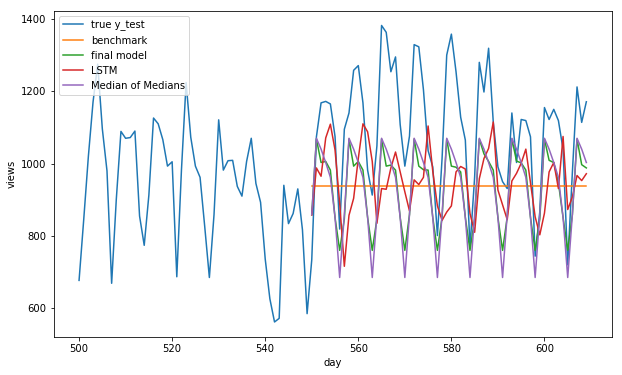

Ohi_Day_en.wikipedia.org_desktop_all-agents


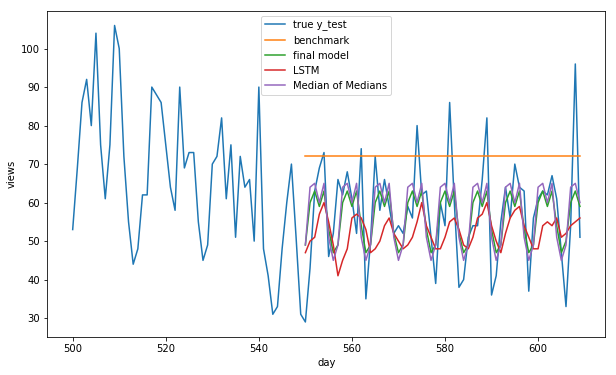

Блэк,_Джек_ru.wikipedia.org_mobile-web_all-agents


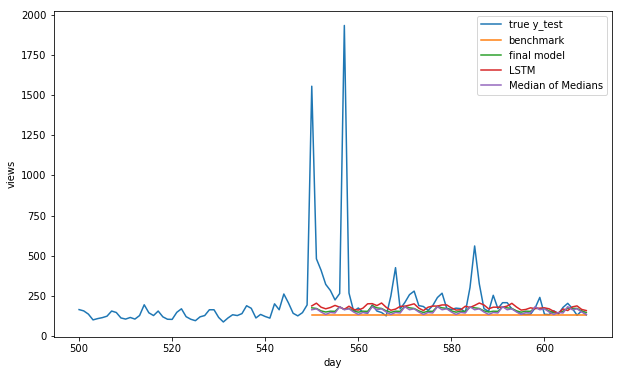

In [229]:
for idx in [5000,10000,18000]:
    plot_pred1(idx)